# How to train your DragoNN tutorial 1: 
## Exploring convolutional neural network (CNN) architectures for simulated genomic data

This tutorial is a supplement to the DragoNN manuscript and follows figure 5 in the manuscript. 

This tutorial will take 20 - 30 minutes if executed on a GPU.

## Outline<a name='outline'>
<ol>
    <li><a href=#1>How to use this tutorial</a></li>
    <li><a href=#2>Review of patterns in transcription factor binding sites</a></li>
    <li><a href=#3>Learning to localize homotypic motif density</a></li>
    <li><a href=#4>Simulate training data with simdna</a></li>  
    <li><a href=#5>Defining CNN architecture</a></li>
    <li><a href=#6>Single layer, single filter model</a></li>
    <li><a href=#7>Single layer, multiple filter model</a></li>
    <li><a href=#8>Model Interpretation</a></li>    
    <li><a href=#9>Multi-layer model</a></li>
    <li><a href=#10>Regularized multi-layer model</a></li>
    TODO: Comparison to LSGKM 
    <li><a href=#11>Further exploration</a></li>    
    <li><a href=#12>Using DragoNN with your own non-simulated data</a></li>
</ol>
Github issues on the dragonn repository with feedback, questions, and discussion are always welcome.

 

## How to use this tutorial<a name='1'>
<a href=#outline>Home</a>

This tutorial utilizes a Jupyter/IPython Notebook - an interactive computational enviroment that combines live code, visualizations, and explanatory text. The notebook is organized into a series of cells. You can run the next cell by cliking the play button:
![play button](./primer_tutorial_images/play_button.png)
You can also run all cells in a series by clicking "run all" in the Cell drop-down menu:
![play all button](./primer_tutorial_images/play_all_button.png)
Half of the cells in this tutorial contain code, the other half contain visualizations and explanatory text. Code, visualizations, and text in cells can be modified - you are encouraged to modify the code as you advance through the tutorial. You can inspect the implementation of a function used in a cell by following these steps:
![inspecting code](./primer_tutorial_images/inspecting_code.png)


In [1]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install https://github.com/kundajelab/simdna/archive/0.3.zip
#!pip install https://github.com/kundajelab/dragonn/archive/keras_2.2_tensorflow_1.6_purekeras.zip


In [2]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)


We start by loading dragonn's tutorial utilities and reviewing properties of regulatory sequence that transcription factors bind.

In [3]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from dragonn.tutorial_utils import *


Using TensorFlow backend.
/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Key properties of regulatory DNA sequences <a name='2'>
<a href=#outline>Home</a>

![sequence properties 1](./primer_tutorial_images/sequence_properties_1.jpg)
![sequence properties 2](./primer_tutorial_images/sequence_properties_2.jpg)

## Learning to localize homotypic motif density <a name='3'>
<a href=#outline>Home</a>

In this tutorial we will learn how to localize a homotypic motif cluster. We will simulate a positive set of sequences with multiple instances of a motif in the center and a negative set of sequences with multiple motif instances positioned anywhere in the sequence:
![homotypic motif density localization](./primer_tutorial_images/homotypic_motif_density_localization.jpg)
We will then train a binary classification model to classify the simulated sequences. To solve this task, the model will need to learn the motif pattern and whether instances of that pattern are present in the central part of the sequence.

![classificatioin task](./tutorial_images/homotypic_motif_density_localization_task.jpg)

We start by getting the simulation data.

## Getting simulation data <a name='4'>
<a href=#outline>Home</a>


DragoNN provides a set of simulation functions. We will use the **simulate_motif_density_localization** function to simulate homotypic motif density localization. First, we obtain documentation for the simulation parameters.

In [4]:
print_simulation_info("simulate_motif_density_localization")


    Simulates two classes of seqeuences:
        - Positive class sequences with multiple motif instances
          in center of the sequence.
        - Negative class sequences with multiple motif instances
          anywhere in the sequence.
    The number of motif instances is uniformly sampled
    between minimum and maximum motif counts.

    Parameters
    ----------
    motif_name : str
        encode motif name
    seq_length : int
        length of sequence
    center_size : int
        length of central part of the sequence where motifs can be positioned
    min_motif_counts : int
        minimum number of motif instances
    max_motif_counts : int
        maximum number of motif instances
    num_pos : int
        number of positive class sequences
    num_neg : int
        number of negative class sequences
    GC_fraction : float
        GC fraction in background sequence

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : 1darra

Next, we define parameters for a TAL1 motif density localization in 1500bp long sequence, with 0.4 GC fraction, and 2-4 instances of the motif in the central 150bp for the positive sequences. We simulate a total of 3000 positive and 3000 negative sequences.

In [5]:
motif_density_localization_simulation_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1500,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4, 
    "num_pos": 3000,
    "num_neg": 3000,
    "GC_fraction": 0.4}

We get the simulation data by calling the **get_simulation_data** function with the simulation name and the simulation parameters as inputs. 1000 sequences are held out for a test set, 1000 sequences for a validation set, and the remaining 4000 sequences are in the training set.

TODO: 

Start with fa.gz files, save to disk. 
You can replace the fa.gz files with your own fasta files. 

In [6]:
simulation_data = get_simulation_data("simulate_motif_density_localization",
                                      motif_density_localization_simulation_parameters,
                                      validation_set_size=1000, test_set_size=1000)

simulation_data provides training, validation, and test sets of input sequences X and sequence labels y. The inputs X are matrices with a one-hot-encoding of the sequences:
<img src="tutorial_images/one_hot_encoding.png" width="500">

Here are the first 10bp of a sequence in our training data:

In [7]:
simulation_data.X_train[0, :, :10, :]

array([[[1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]]], dtype=int32)

We can convert this one-hot-encoded matrix back into a DNA string:

In [8]:
from dragonn.utils import *
get_sequence_strings(simulation_data.X_train)[0][:10]

b'AAGTGCAAAA'

Let's examine the shape of training, validation, and test matrices: 

In [9]:
print(simulation_data.X_train.shape)
print(simulation_data.y_train.shape)

(4000, 1, 1500, 4)
(4000, 1)


In [10]:
print(simulation_data.X_valid.shape)
print(simulation_data.y_valid.shape)

(1000, 1, 1500, 4)
(1000, 1)


In [11]:
print(simulation_data.X_test.shape)
print(simulation_data.y_test.shape)

(1000, 1, 1500, 4)
(1000, 1)


# Defining the convolutional neural network model architecture  <a name='5'>
<a href=#outline>Home</a>

A locally connected linear unit in a CNN model can represent a PSSM (part a). A sequence PSSM score is obtained by multiplying the PSSM across the sequence, thresholding the PSSM scores, and taking the max (part b). A PSSM score can also be computed by a CNN model with tiled, locally connected linear units, amounting to a convolutional layer with a single convolutional filter representing the PSSM, followed by ReLU thresholding and maxpooling (part c).
![dragonn vs pssm](./tutorial_images/dragonn_and_pssm.jpg)
By utilizing multiple convolutional layers with multiple convolutional filters, CNN's can represent a wide range of sequence features in a compositional fashion:
![dragonn model figure](./tutorial_images/dragonn_model_figure.jpg)

We will use the deep learning library [keras](http://keras.io/) with the [TensorFlow](https://github.com/tensorflow/tensorflow) backend to generate and train the CNN models. 

In [12]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')


# Single layer, single filter model <a name='6'>
<a href=#outline>Home</a>


We define a simple DragoNN model with one convolutional layer with one convolutional filter, followed by maxpooling of width 35. 
The model parameters are: 


TODO: Explain the parameters. 

* input sequence length 1500 
* 1 filter 
* convolutional kernels of width 10 
* max pool of width 35 


In [13]:
#Define the model architecture in keras
one_filter_keras_model=Sequential() 
one_filter_keras_model.add(Conv2D(filters=1,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
one_filter_keras_model.add(Activation('relu'))
one_filter_keras_model.add(MaxPooling2D(pool_size=(1,35)))
one_filter_keras_model.add(Flatten())
one_filter_keras_model.add(Dense(1))
one_filter_keras_model.add(Activation("sigmoid"))

In [14]:
one_filter_keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1491, 1)        41        
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1491, 1)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 42, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 43        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


In [15]:
##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
one_filter_keras_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

We train the model for 150 epochs, with an early stopping criterion -- if the loss on the validation set does not improve for five consecutive epochs, the training is halted. In each epoch, the one_filter_dragonn performed a complete pass over the training data, and updated its parameters to minimize the loss, which quantifies the error in the model predictions. After each epoch, the performance metrics for the one_filter_dragonn on the validation data were stored. 

The performance metrics include balanced accuracy, area under the receiver-operating curve ([auROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)), are under the precision-recall curve ([auPRC](https://en.wikipedia.org/wiki/Precision_and_recall)), and recall for multiple false discovery rates  (Recall at [FDR](https://en.wikipedia.org/wiki/False_discovery_rate)).

In [16]:
from dragonn.callbacks import * 
#We define a custom callback to print training and validation metrics while training. 
metrics_callback=MetricsCallback(train_data=(simulation_data.X_train,simulation_data.y_train),
                                 validation_data=(simulation_data.X_valid,simulation_data.y_valid))


In [17]:
## use the keras fit function to train the model for 150 epochs with early stopping after 3 epochs 
history_one_filter=one_filter_keras_model.fit(x=simulation_data.X_train,
                                  y=simulation_data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=1,
                                  callbacks=[EarlyStopping(patience=3),
                                            History(),
                                            metrics_callback],
                                  validation_data=(simulation_data.X_valid,
                                                   simulation_data.y_valid))


Train on 4000 samples, validate on 1000 samples
Epoch 1/150
4000/4000 [==============================] - 9s 2ms/step - loss: 0.7048 - val_loss: 0.7034
Training Data:
Loss: 0.7022	Balanced Accuracy: 51.54%	 auROC: 0.510	 auPRC: 0.494
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.7034	Balanced Accuracy: 49.22%	 auROC: 0.502	 auPRC: 0.530
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 528	 Num Negatives: 472
Epoch 2/150
4000/4000 [==============================] - 0s 81us/step - loss: 0.7015 - val_loss: 0.7030
Training Data:
Loss: 0.6999	Balanced Accuracy: 52.28%	 auROC: 0.514	 auPRC: 0.498
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.7030	Balanced Accuracy: 48.89%	 auROC: 0.504	 auPRC: 0.533
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 528	 Num Negatives: 472
Epoch 3/150
4000/4000 [==============================] - 0s 67us/step - loss: 0.7

### Evaluate the model on the held-out test set 

In [18]:
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=one_filter_keras_model.predict(simulation_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(simulation_data.y_test,test_predictions))

Loss: 0.7045	Balanced Accuracy: 48.09%	 auROC: 0.484	 auPRC: 0.507
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|1.0%	 Num Positives: 515	 Num Negatives: 485


### Visualize the model's performance

We can see that the validation loss is not decreasing and the auROC metric is not decreasing, which indicates this model is not learning. A simple plot of the learning curve, showing the loss function on the training and validation data over the course of training, demonstrates this visually:

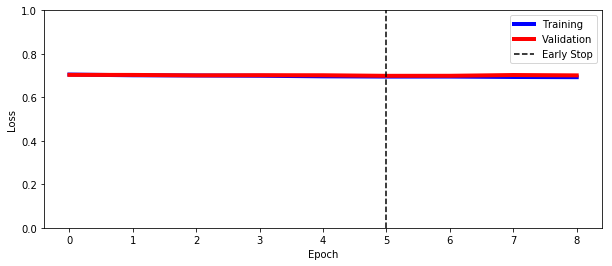

In [19]:
from dragonn.tutorial_utils import plot_learning_curve
plot_learning_curve(history_one_filter)

## Visualize the learned parameters 

Next, let's visualize the filter learned in this model

### Dense layer

In [20]:
W_dense, b_dense = one_filter_keras_model.layers[-2].get_weights()

In [21]:
b_dense

array([0.00602223], dtype=float32)

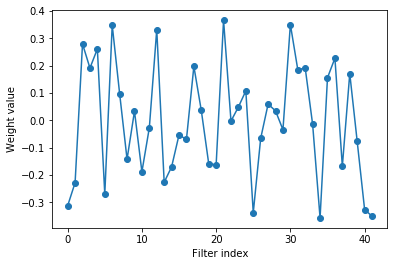

In [22]:
plt.plot(W_dense, "-o")
plt.xlabel("Filter index")
plt.ylabel("Weight value");

### Convolutional layer 

In [23]:
W_conv, b_conv = one_filter_keras_model.layers[0].get_weights()

In [24]:
W_conv.shape

(1, 10, 4, 1)

In [25]:
b_conv.shape

(1,)

Plotting simulation motifs...


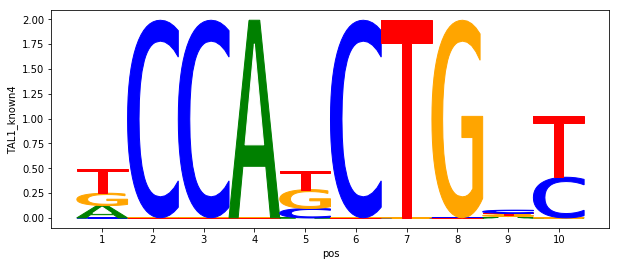

Visualizing convolutional sequence filters in SequenceDNN...


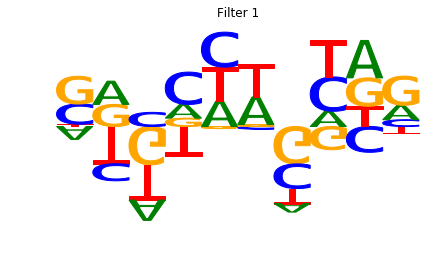

In [26]:
from dragonn.tutorial_utils import interpret_filters

interpret_filters(one_filter_keras_model, simulation_data)

# A multi-filter DragoNN model <a name='7'>
<a href=#outline>Home</a>

Next, we modify the model to have 15 convolutional filters instead of just one filter. Will the model learn now?

In [27]:
#Define the model architecture in keras
multi_filter_keras_model=Sequential() 
multi_filter_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
multi_filter_keras_model.add(Activation('relu'))
multi_filter_keras_model.add(MaxPooling2D(pool_size=(1,35)))
multi_filter_keras_model.add(Flatten())
multi_filter_keras_model.add(Dense(1))
multi_filter_keras_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
multi_filter_keras_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

In [28]:
multi_filter_keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 1491, 15)       615       
_________________________________________________________________
activation_3 (Activation)    (None, 1, 1491, 15)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 42, 15)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 630)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 631       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 1,246
Trainable params: 1,246
Non-trainable params: 0
_________________________________________________________________


In [29]:
## use the keras fit function to train the model for 150 epochs with early stopping after 3 epochs 
history_multi_filter=multi_filter_keras_model.fit(x=simulation_data.X_train,
                                  y=simulation_data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=1,
                                  callbacks=[EarlyStopping(patience=3),
                                            History(),
                                            metrics_callback],
                                  validation_data=(simulation_data.X_valid,
                                                   simulation_data.y_valid))


Train on 4000 samples, validate on 1000 samples
Epoch 1/150
4000/4000 [==============================] - 2s 428us/step - loss: 0.7069 - val_loss: 0.7069
Training Data:
Loss: 0.6928	Balanced Accuracy: 51.96%	 auROC: 0.536	 auPRC: 0.518
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.7069	Balanced Accuracy: 46.61%	 auROC: 0.464	 auPRC: 0.499
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 528	 Num Negatives: 472
Epoch 2/150
4000/4000 [==============================] - 0s 84us/step - loss: 0.6924 - val_loss: 0.6987
Training Data:
Loss: 0.6888	Balanced Accuracy: 54.80%	 auROC: 0.565	 auPRC: 0.543
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.6987	Balanced Accuracy: 48.32%	 auROC: 0.469	 auPRC: 0.505
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 528	 Num Negatives: 472
Epoch 3/150
4000/4000 [==============================] - 0s 75us/step - loss: 0

4000/4000 [==============================] - 0s 74us/step - loss: 0.2120 - val_loss: 0.2237
Training Data:
Loss: 0.2054	Balanced Accuracy: 93.63%	 auROC: 0.982	 auPRC: 0.980
	Recall at 5%|10%|20% FDR: 90.1%|97.0%|99.5%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.2237	Balanced Accuracy: 91.06%	 auROC: 0.977	 auPRC: 0.978
	Recall at 5%|10%|20% FDR: 85.0%|94.5%|100.0%	 Num Positives: 528	 Num Negatives: 472
Epoch 21/150
4000/4000 [==============================] - 0s 73us/step - loss: 0.2016 - val_loss: 0.2131
Training Data:
Loss: 0.1970	Balanced Accuracy: 93.75%	 auROC: 0.983	 auPRC: 0.980
	Recall at 5%|10%|20% FDR: 90.6%|97.2%|99.5%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.2131	Balanced Accuracy: 91.36%	 auROC: 0.978	 auPRC: 0.978
	Recall at 5%|10%|20% FDR: 85.2%|94.5%|100.0%	 Num Positives: 528	 Num Negatives: 472
Epoch 22/150
4000/4000 [==============================] - 0s 76us/step - loss: 0.1947 - val_loss: 0.2101
Training Data:
Loss:

In [30]:
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=multi_filter_keras_model.predict(simulation_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(simulation_data.y_test,test_predictions))

Loss: 0.1995	Balanced Accuracy: 91.83%	 auROC: 0.981	 auPRC: 0.982
	Recall at 5%|10%|20% FDR: 90.3%|95.1%|99.2%	 Num Positives: 515	 Num Negatives: 485


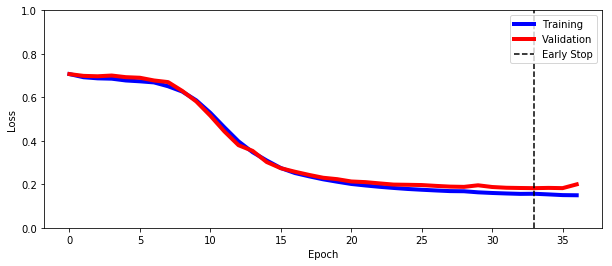

In [31]:
## Visualize the model's performance 
plot_learning_curve(history_multi_filter)

Plotting simulation motifs...


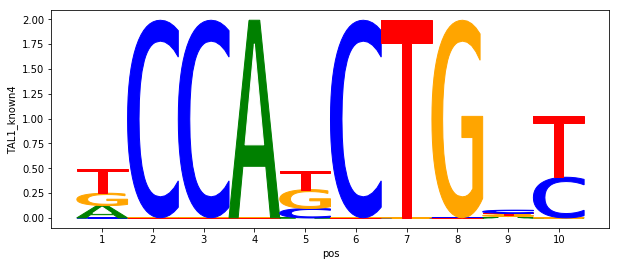

Visualizing convolutional sequence filters in SequenceDNN...


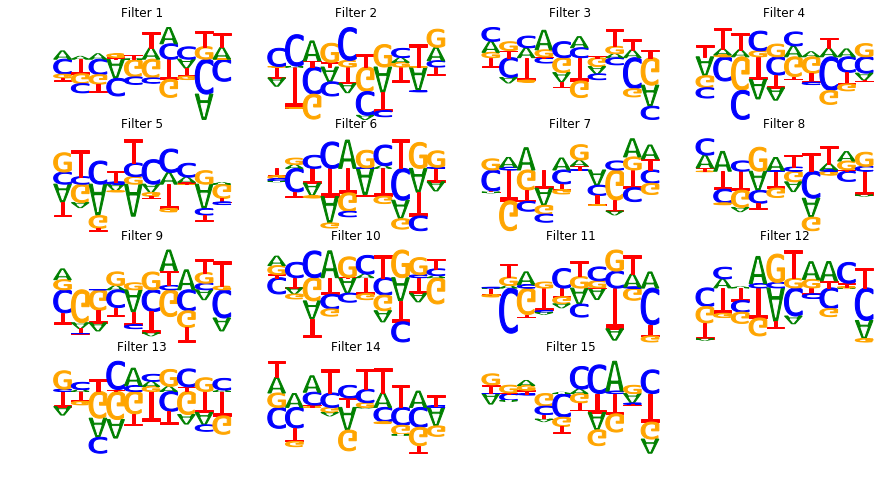

In [32]:
## Visualize the motifs learned by the model
interpret_filters(multi_filter_keras_model, simulation_data)

# Model Interpretation <a name='8'>
<a href=#outline>Home</a>


As you can see, the filters/model parameters are difficult to be interepreted directly. However, there are alternative approaches of interepreting sequences.

Let's examine a positive and negative example from our simulation data:

TODO: indicate that another negative can be generated to increase distance from positives. 

In [33]:
#get the indices of the first positive and negative examples in the validation data split
pos_indx=np.flatnonzero(simulation_data.y_valid==1)[0]
print(pos_indx)
pos_X=simulation_data.X_valid[pos_indx:pos_indx+1]

neg_indx=np.flatnonzero(simulation_data.y_valid==0)[1]
print(neg_indx)
neg_X=simulation_data.X_valid[neg_indx:neg_indx+1]

2
1


### Motif Scores

In [34]:
pos_motif_scores=get_motif_scores(pos_X,simulation_data.motif_names,return_positions=True).squeeze()
neg_motif_scores=get_motif_scores(neg_X,simulation_data.motif_names,return_positions=True).squeeze()

Text(0.5, 1.0, 'Positive example')

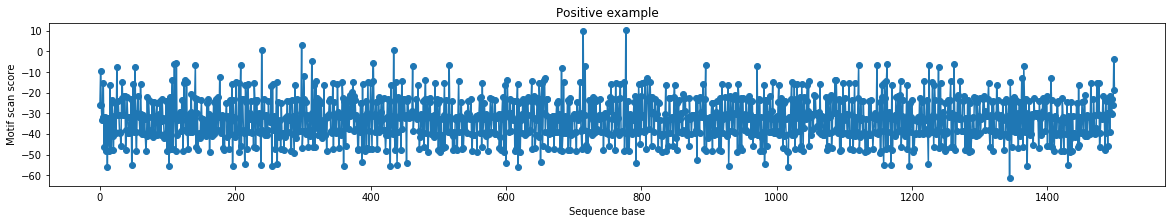

In [35]:
plt.figure(figsize=(20,3))
plt.plot(pos_motif_scores, "-o")
plt.xlabel("Sequence base")
plt.ylabel("Motif scan score")
plt.title("Positive example")


Text(0.5, 1.0, 'Negative example')

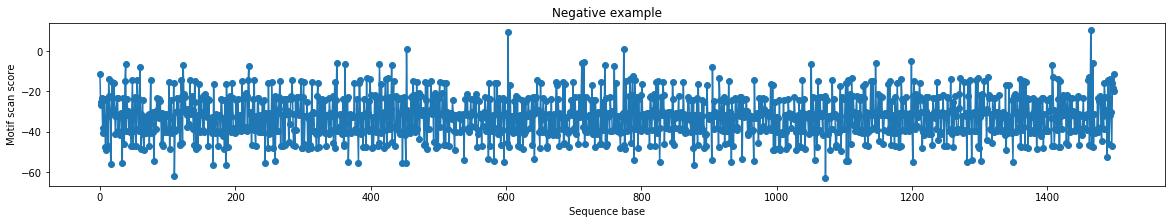

In [36]:
plt.figure(figsize=(20,3))
plt.plot(neg_motif_scores, "-o")
plt.xlabel("Sequence base")
plt.ylabel("Motif scan score")
plt.title("Negative example")


The motif scan yields a group of three high-scoring motif alignment positions at a fixed distance near the center of the sequence in the positive example. The spacing of the high-scoring motif alignments is random in the negative sequence. 

### In silico mutagenesis 

To determine how much each position in the input sequence contrinbutes to the model's prediction, we can perform saturation mutagenesis on the sequence. For each position in the input sequence, we introduce each of the four possible bases A, C, G, T and quantify the effect on the model's predictions.


TODO: Explain what ISM is doing, equation from dragonn code. 
TODO: Update ISM to reflect the difference of logits. 

In [37]:
from dragonn.tutorial_utils import in_silico_mutagenesis, plot_ism
ism_pos=in_silico_mutagenesis(multi_filter_keras_model,pos_X)
ism_neg=in_silico_mutagenesis(multi_filter_keras_model,neg_X)

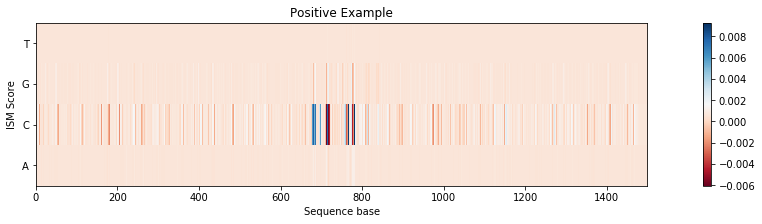

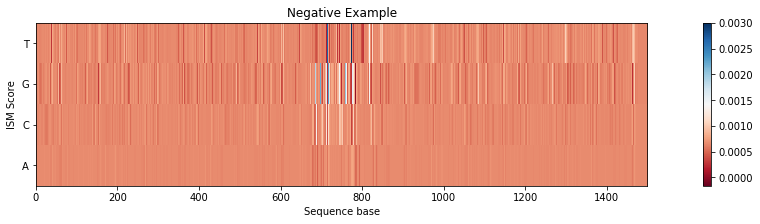

In [38]:
# create discrete colormap of ISM scores 
from dragonn.tutorial_utils import plot_ism
plot_ism(ism_pos,"Positive Example")
plot_ism(ism_neg,"Negative Example")

### Gradient x Input 

Consider a neural net being a function: $f(x_1, ..., x_N; w) = y$

One way to tell whether the input feature is important is to compute the gradient of the function with respect to (w.r.t.) model input: $\frac{\partial f}{\partial x_i}$

This approach is called saliency maps: "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", by Karen Simonyan, Andrea Vedaldi and Andrew Zisserma https://arxiv.org/pdf/1312.6034.pdf

In genomics, we typically visualize only gradients for bases observed in the sequence (called input masked gradients or input*grad).

In [39]:
from dragonn.tutorial_utils import  input_grad,plot_seq_importance

In [40]:
gradinput_pos=input_grad(multi_filter_keras_model,pos_X)
gradinput_neg=input_grad(multi_filter_keras_model,neg_X)

Positive:


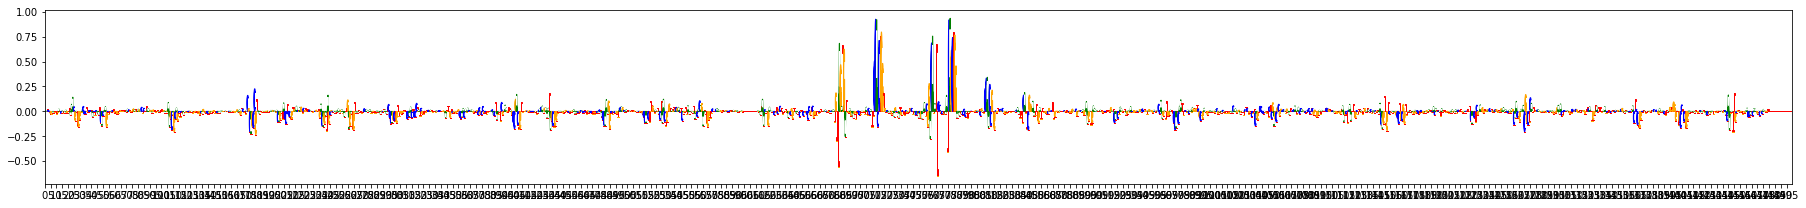

In [41]:
print("Positive:")
plot_seq_importance(gradinput_pos,pos_X)


Negative:


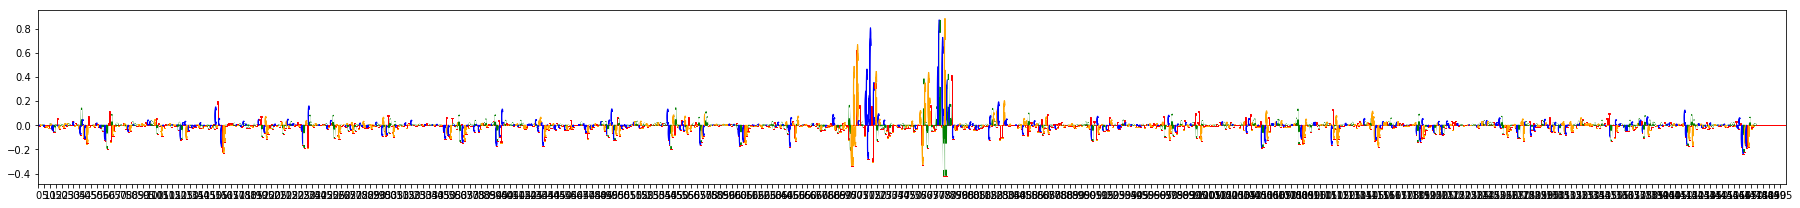

In [42]:
print("Negative:")
plot_seq_importance(gradinput_neg,neg_X)

Let's zoom in to the center 150 bp of the sequence, where the simulated homotypic motif grammar is to be found. 

Positive:


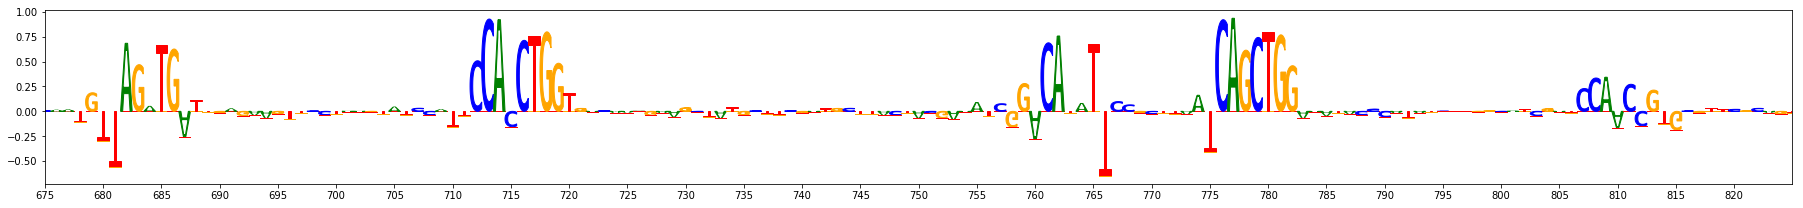

In [43]:
print("Positive:")
plot_seq_importance(gradinput_pos,pos_X,xlim=(675,825))

Negative:


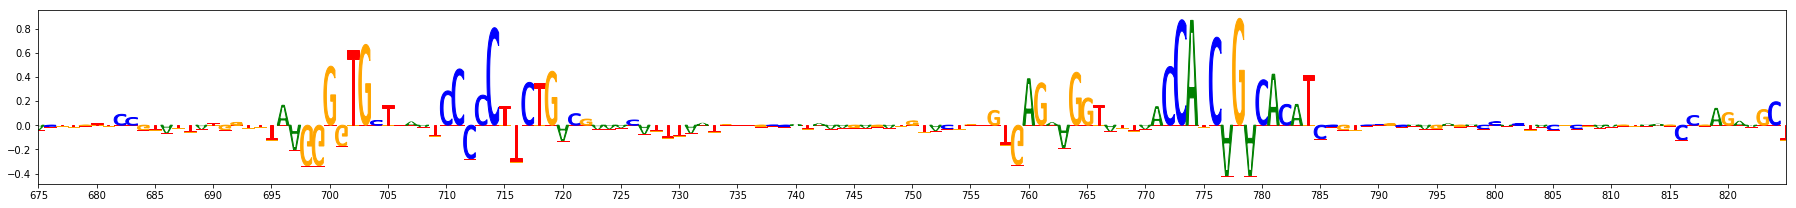

In [44]:
print("Negative:")
plot_seq_importance(gradinput_neg,neg_X,xlim=(675,825))

### DeepLIFT

[DeepLIFT](https://arxiv.org/pdf/1605.01713v2.pdf) allows us to obtain scores for specific sequence indicating the importance of each position in the sequence. DeepLIFT can accept a custom reference. For our purposes, we provide a 40% GC reference. 


TODO: use a dinucleotide-shuffled reference. 


In [45]:
from dragonn.tutorial_utils import deeplift

dl_pos=deeplift(multi_filter_keras_model,pos_X)
dl_neg=deeplift(multi_filter_keras_model,neg_X)

In [46]:
input_references = (np.array([0.3, 0.2, 0.2, 0.3])[None, None, None, :])*np.ones((1,1,1500,4))

multi_filter_keras_model.predict(input_references)

array([[0.4926329]], dtype=float32)

Positive:


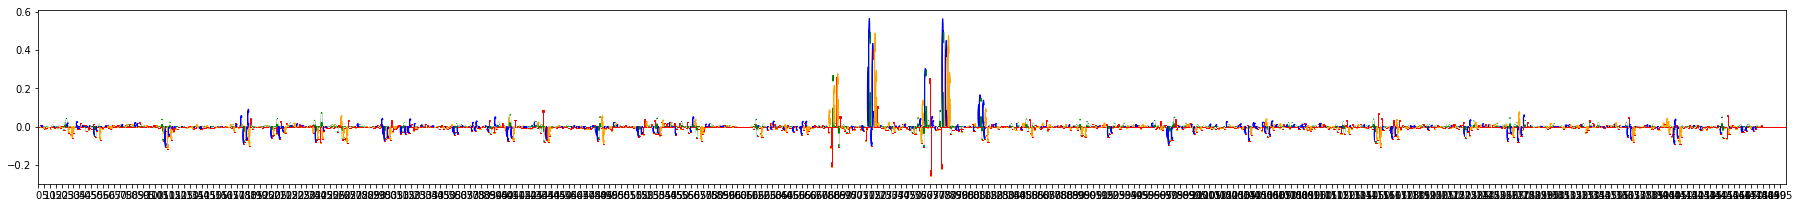

In [47]:
print("Positive:")
plot_seq_importance(dl_pos,pos_X)


Negative:


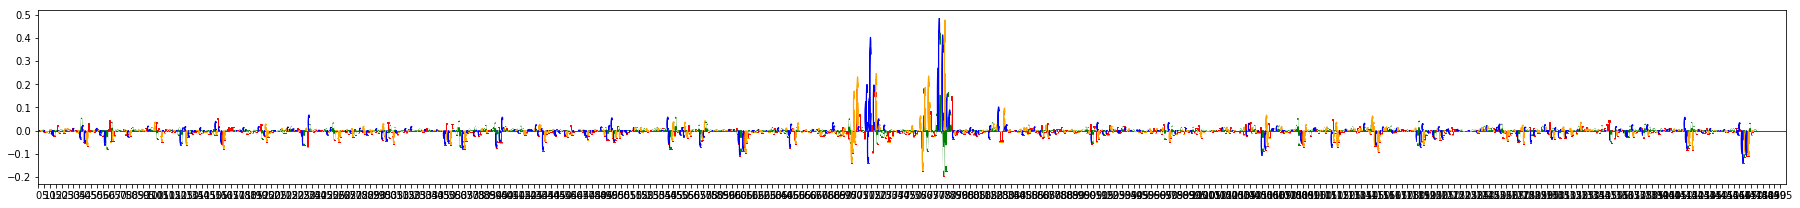

In [48]:
print("Negative:")
plot_seq_importance(dl_neg,neg_X)

Zooming in to the 150 bases at the center of the sequence: 

Positive:


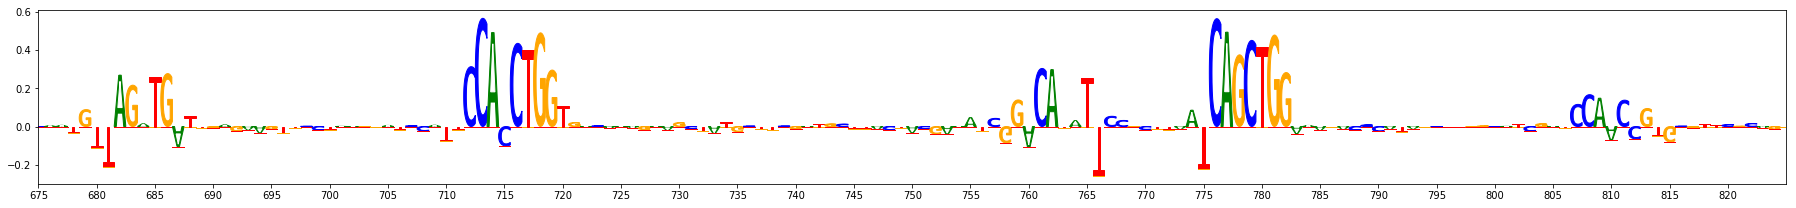

In [49]:
print("Positive:")
plot_seq_importance(dl_pos,pos_X,xlim=(675,825))

Negative:


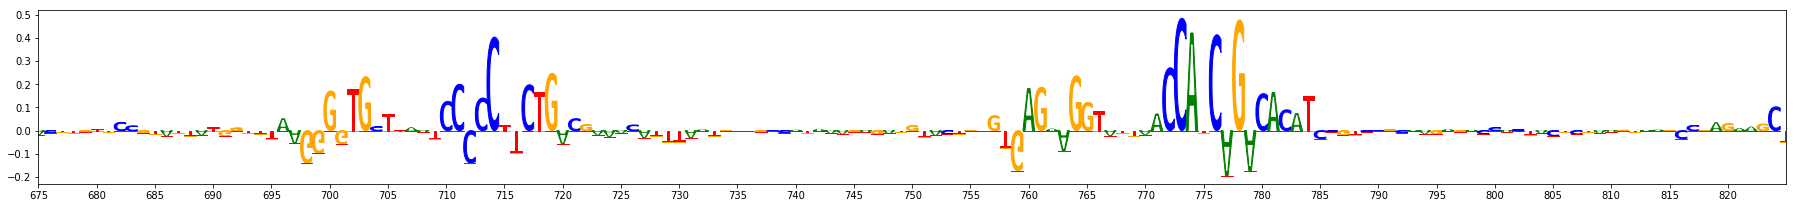

In [50]:
print("Negative:")
plot_seq_importance(dl_neg,neg_X,xlim=(675,825))

# A multi-layer DragoNN model <a name='9'>

<a href=#outline>Home</a> 

Next, we train a 3 layer model for this task. Will it outperform the single layer model and to what extent will it overfit?

In [51]:
#Define the model architecture in keras
multi_layer_keras_model=Sequential() 
multi_layer_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
multi_layer_keras_model.add(Activation('relu'))
multi_layer_keras_model.add(MaxPooling2D(pool_size=(1,35)))

multi_layer_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
multi_layer_keras_model.add(Activation('relu'))

multi_layer_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
multi_layer_keras_model.add(Activation('relu'))


multi_layer_keras_model.add(Flatten())
multi_layer_keras_model.add(Dense(1))
multi_layer_keras_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
multi_layer_keras_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

multi_layer_keras_model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1, 1491, 15)       615       
_________________________________________________________________
activation_5 (Activation)    (None, 1, 1491, 15)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 42, 15)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 33, 15)         2265      
_________________________________________________________________
activation_6 (Activation)    (None, 1, 33, 15)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 24, 15)         2265      
_________________________________________________________________
activation_7 (Activation)    (None, 1, 24, 15)         0         
__________

In [52]:
## use the keras fit function to train the model for 150 epochs with early stopping after 3 epochs 
history_multi_layer=multi_layer_keras_model.fit(x=simulation_data.X_train,
                                  y=simulation_data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=1,
                                  callbacks=[EarlyStopping(patience=3),
                                            History(),
                                            metrics_callback],
                                  validation_data=(simulation_data.X_valid,
                                                   simulation_data.y_valid))


Train on 4000 samples, validate on 1000 samples
Epoch 1/150
4000/4000 [==============================] - 3s 676us/step - loss: 0.6941 - val_loss: 0.7005
Training Data:
Loss: 0.6926	Balanced Accuracy: 50.13%	 auROC: 0.547	 auPRC: 0.534
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.7005	Balanced Accuracy: 49.99%	 auROC: 0.526	 auPRC: 0.541
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.9%	 Num Positives: 528	 Num Negatives: 472
Epoch 2/150
4000/4000 [==============================] - 0s 87us/step - loss: 0.6875 - val_loss: 0.6756
Training Data:
Loss: 0.6735	Balanced Accuracy: 68.19%	 auROC: 0.754	 auPRC: 0.743
	Recall at 5%|10%|20% FDR: 4.7%|12.8%|33.0%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.6756	Balanced Accuracy: 66.03%	 auROC: 0.723	 auPRC: 0.743
	Recall at 5%|10%|20% FDR: 4.7%|10.4%|27.3%	 Num Positives: 528	 Num Negatives: 472
Epoch 3/150
4000/4000 [==============================] - 0s 90us/step - los

In [53]:
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=multi_layer_keras_model.predict(simulation_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(simulation_data.y_test,test_predictions))

Loss: 0.1439	Balanced Accuracy: 94.25%	 auROC: 0.988	 auPRC: 0.989
	Recall at 5%|10%|20% FDR: 95.0%|97.5%|99.8%	 Num Positives: 515	 Num Negatives: 485


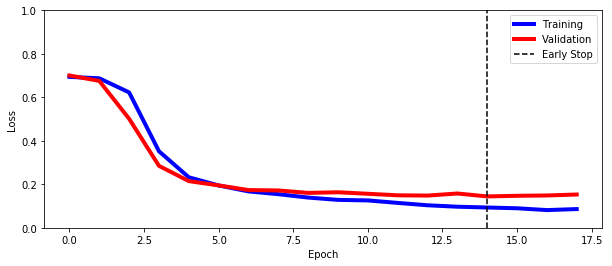

In [54]:
## Visualize the model's performance 
plot_learning_curve(history_multi_layer)

In [55]:
ism_pos=in_silico_mutagenesis(multi_layer_keras_model,pos_X)
ism_neg=in_silico_mutagenesis(multi_layer_keras_model,neg_X)

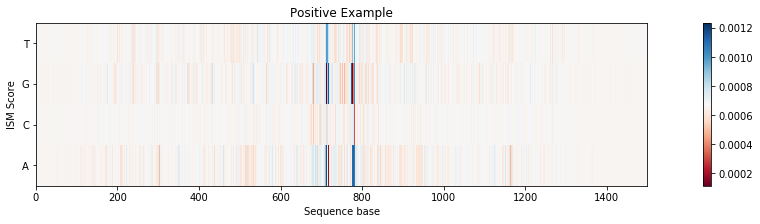

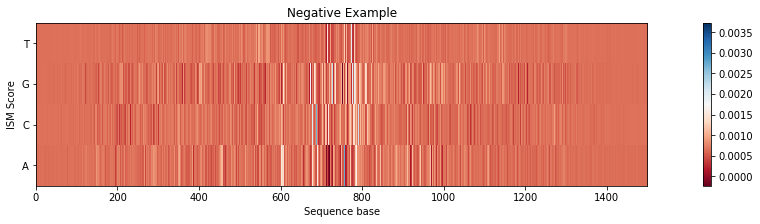

In [56]:
# create discrete colormap of ISM scores 
plot_ism(ism_pos,'Positive Example')
plot_ism(ism_neg,'Negative Example')

In [57]:
dl_pos=deeplift(multi_layer_keras_model,pos_X)
dl_neg=deeplift(multi_layer_keras_model,neg_X)
gradinput_pos=input_grad(multi_layer_keras_model,pos_X)
gradinput_neg=input_grad(multi_layer_keras_model,neg_X)

Positive:


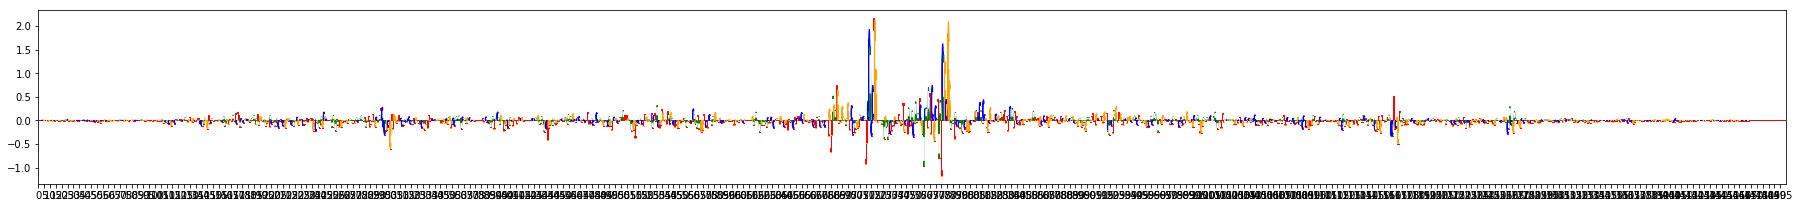

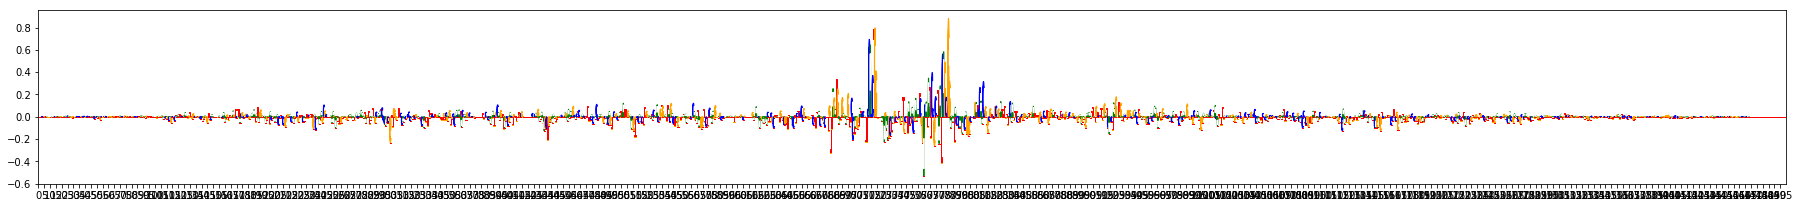

In [58]:
print("Positive:")
plot_seq_importance(gradinput_pos,pos_X)
plot_seq_importance(dl_pos,pos_X)


Negative:


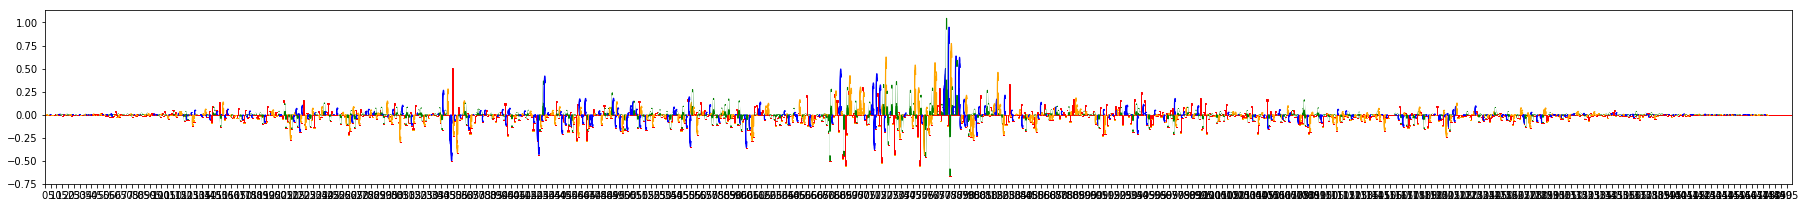

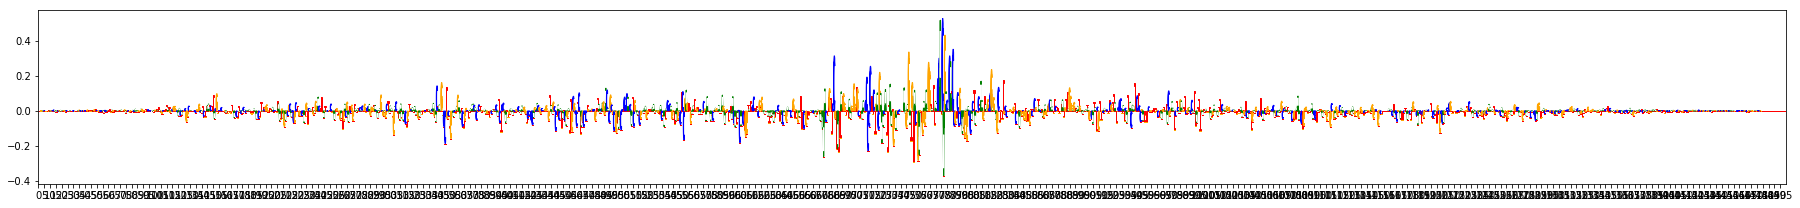

In [59]:
print("Negative:")
plot_seq_importance(gradinput_neg,neg_X)
plot_seq_importance(dl_neg,neg_X)

Zooming in to the center of the sequence: 

Positive:


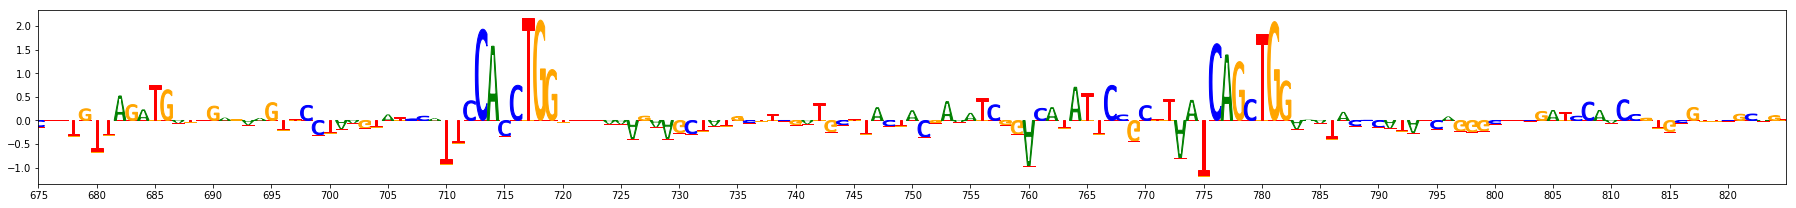

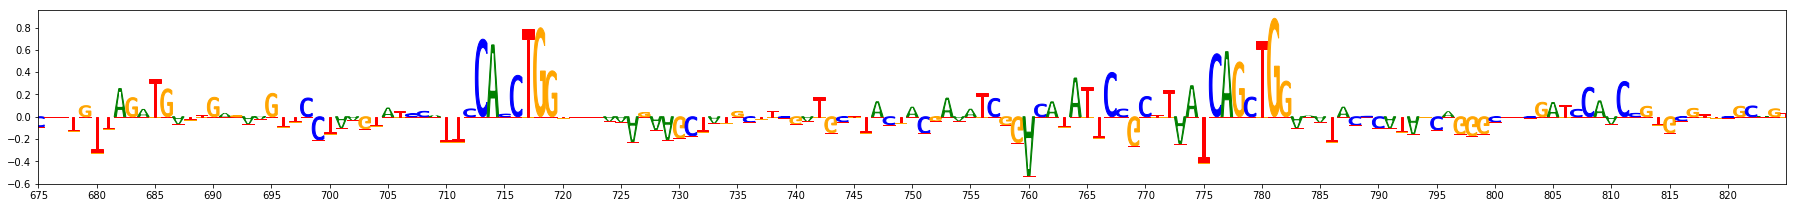

In [60]:
print("Positive:")
plot_seq_importance(gradinput_pos,pos_X,xlim=(675,825))
plot_seq_importance(dl_pos,pos_X,xlim=(675,825))


Negative:


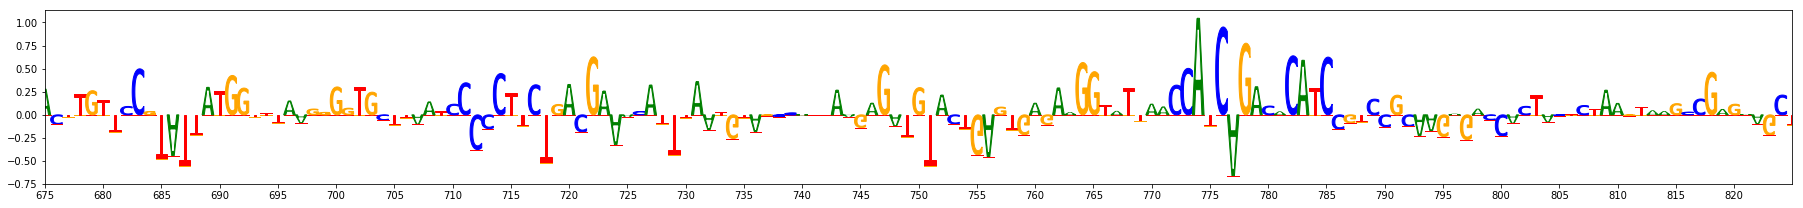

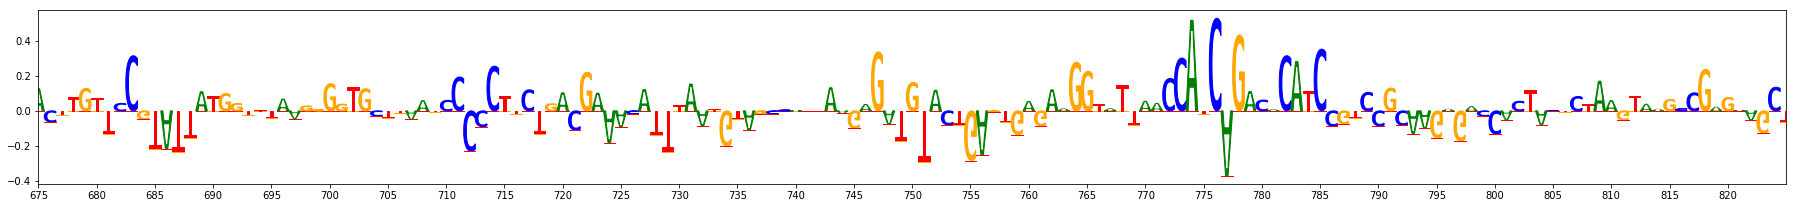

In [61]:
print("Negative:")
plot_seq_importance(gradinput_neg,neg_X,xlim=(675,825))
plot_seq_importance(dl_neg,neg_X,xlim=(675,825))


This model performs slightly better than the single layer model but it overfits more. We will try to address that with dropout regularization.

# A regularized multi-layer DragoNN model <a name='10'>
    
<a href=#outline>Home</a> 
    
Next, we regularize the 3 layer using 0.2 dropout on every convolutional layer. Will dropout improve validation performance?

In [62]:
#Define the model architecture in keras
regularized_keras_model=Sequential() 
regularized_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
regularized_keras_model.add(Activation('relu'))
regularized_keras_model.add(Dropout(0.2))
regularized_keras_model.add(MaxPooling2D(pool_size=(1,35)))

regularized_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
regularized_keras_model.add(Activation('relu'))
regularized_keras_model.add(Dropout(0.2))

regularized_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
regularized_keras_model.add(Activation('relu'))
regularized_keras_model.add(Dropout(0.2))


regularized_keras_model.add(Flatten())
regularized_keras_model.add(Dense(1))
regularized_keras_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
regularized_keras_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

regularized_keras_model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 1, 1491, 15)       615       
_________________________________________________________________
activation_9 (Activation)    (None, 1, 1491, 15)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1491, 15)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 42, 15)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 33, 15)         2265      
_________________________________________________________________
activation_10 (Activation)   (None, 1, 33, 15)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 33, 15)         0         
__________

In [63]:
## use the keras fit function to train the model for 150 epochs with early stopping after 3 epochs 
history_regularized=regularized_keras_model.fit(x=simulation_data.X_train,
                                  y=simulation_data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=1,
                                  callbacks=[EarlyStopping(patience=3),
                                            History(),
                                            metrics_callback],
                                  validation_data=(simulation_data.X_valid,
                                                   simulation_data.y_valid))


Train on 4000 samples, validate on 1000 samples
Epoch 1/150
4000/4000 [==============================] - 3s 661us/step - loss: 0.6960 - val_loss: 0.6957
Training Data:
Loss: 0.6906	Balanced Accuracy: 50.80%	 auROC: 0.561	 auPRC: 0.536
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.6957	Balanced Accuracy: 50.73%	 auROC: 0.521	 auPRC: 0.556
	Recall at 5%|10%|20% FDR: 0.8%|0.8%|1.9%	 Num Positives: 528	 Num Negatives: 472
Epoch 2/150
4000/4000 [==============================] - 0s 100us/step - loss: 0.6892 - val_loss: 0.6831
Training Data:
Loss: 0.6825	Balanced Accuracy: 65.18%	 auROC: 0.704	 auPRC: 0.680
	Recall at 5%|10%|20% FDR: 0.1%|0.8%|8.3%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.6831	Balanced Accuracy: 63.87%	 auROC: 0.683	 auPRC: 0.700
	Recall at 5%|10%|20% FDR: 1.3%|1.7%|16.7%	 Num Positives: 528	 Num Negatives: 472
Epoch 3/150
4000/4000 [==============================] - 0s 105us/step - loss

4000/4000 [==============================] - 0s 100us/step - loss: 0.1442 - val_loss: 0.1251
Training Data:
Loss: 0.1089	Balanced Accuracy: 96.11%	 auROC: 0.994	 auPRC: 0.993
	Recall at 5%|10%|20% FDR: 97.9%|99.6%|100.0%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.1251	Balanced Accuracy: 94.83%	 auROC: 0.990	 auPRC: 0.991
	Recall at 5%|10%|20% FDR: 96.4%|99.1%|100.0%	 Num Positives: 528	 Num Negatives: 472
Epoch 21/150
4000/4000 [==============================] - 0s 99us/step - loss: 0.1396 - val_loss: 0.1252
Training Data:
Loss: 0.1042	Balanced Accuracy: 96.53%	 auROC: 0.995	 auPRC: 0.994
	Recall at 5%|10%|20% FDR: 98.7%|99.7%|100.0%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.1252	Balanced Accuracy: 94.96%	 auROC: 0.991	 auPRC: 0.991
	Recall at 5%|10%|20% FDR: 96.4%|99.1%|100.0%	 Num Positives: 528	 Num Negatives: 472
Epoch 22/150
4000/4000 [==============================] - 0s 104us/step - loss: 0.1452 - val_loss: 0.1222
Training Data:
L

4000/4000 [==============================] - 0s 93us/step - loss: 0.1113 - val_loss: 0.0986
Training Data:
Loss: 0.0698	Balanced Accuracy: 97.50%	 auROC: 0.998	 auPRC: 0.997
	Recall at 5%|10%|20% FDR: 99.6%|100.0%|100.0%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.0986	Balanced Accuracy: 96.17%	 auROC: 0.994	 auPRC: 0.994
	Recall at 5%|10%|20% FDR: 98.5%|99.6%|100.0%	 Num Positives: 528	 Num Negatives: 472
Epoch 40/150
4000/4000 [==============================] - 0s 88us/step - loss: 0.0942 - val_loss: 0.0903
Training Data:
Loss: 0.0601	Balanced Accuracy: 97.73%	 auROC: 0.998	 auPRC: 0.998
	Recall at 5%|10%|20% FDR: 99.7%|99.9%|100.0%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.0903	Balanced Accuracy: 96.93%	 auROC: 0.994	 auPRC: 0.994
	Recall at 5%|10%|20% FDR: 99.4%|99.6%|100.0%	 Num Positives: 528	 Num Negatives: 472
Epoch 41/150
4000/4000 [==============================] - 0s 91us/step - loss: 0.0984 - val_loss: 0.0922
Training Data:
Lo

In [64]:
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=regularized_keras_model.predict(simulation_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(simulation_data.y_test,test_predictions))

Loss: 0.0787	Balanced Accuracy: 96.75%	 auROC: 0.997	 auPRC: 0.997
	Recall at 5%|10%|20% FDR: 99.8%|100.0%|100.0%	 Num Positives: 515	 Num Negatives: 485


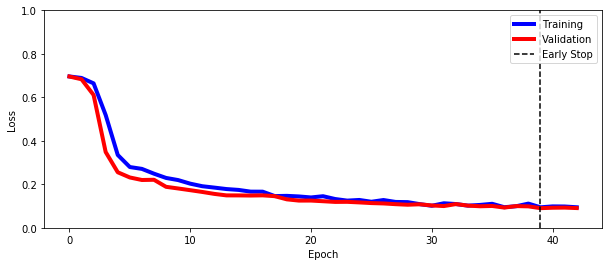

In [65]:
## Visualize the model's performance 
plot_learning_curve(history_regularized)

In [66]:
ism_pos=in_silico_mutagenesis(regularized_keras_model,pos_X)
ism_neg=in_silico_mutagenesis(regularized_keras_model,neg_X)

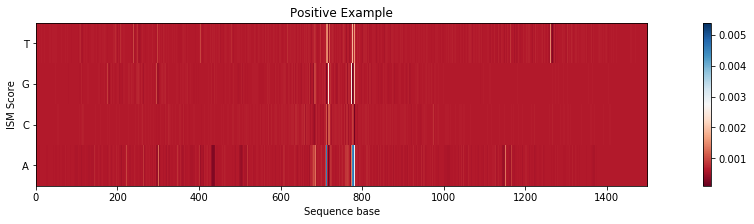

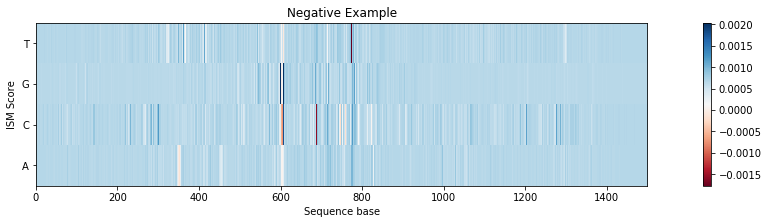

In [67]:
plot_ism(ism_pos,'Positive Example')
plot_ism(ism_neg,'Negative Example')

In [68]:
dl_pos=deeplift(regularized_keras_model,pos_X)
dl_neg=deeplift(regularized_keras_model,neg_X)
gradinput_pos=input_grad(regularized_keras_model,pos_X).squeeze()
gradinput_neg=input_grad(regularized_keras_model,neg_X).squeeze()

Positive:


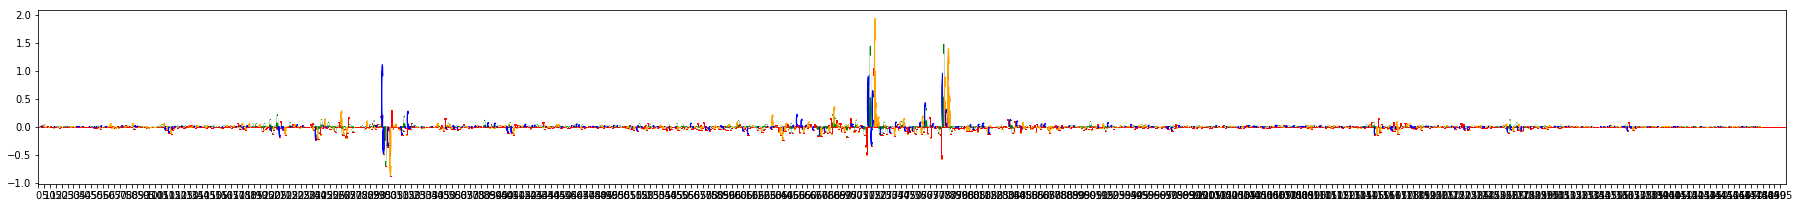

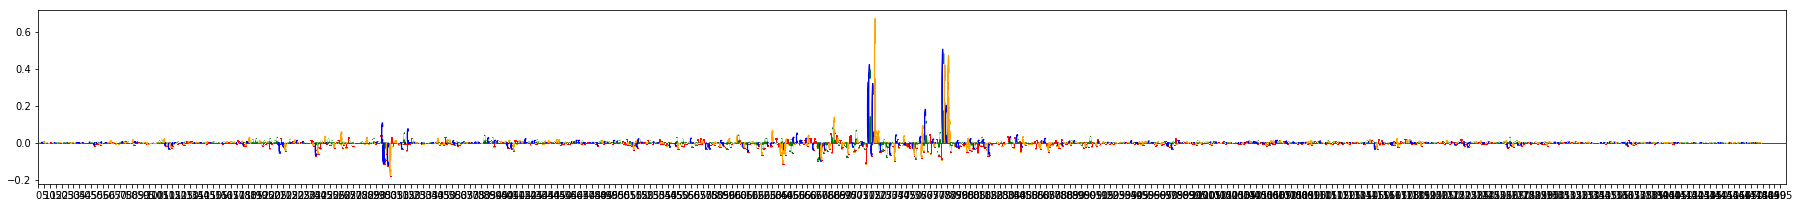

In [69]:
print("Positive:")
plot_seq_importance(gradinput_pos,pos_X)
plot_seq_importance(dl_pos,pos_X)

Negative:


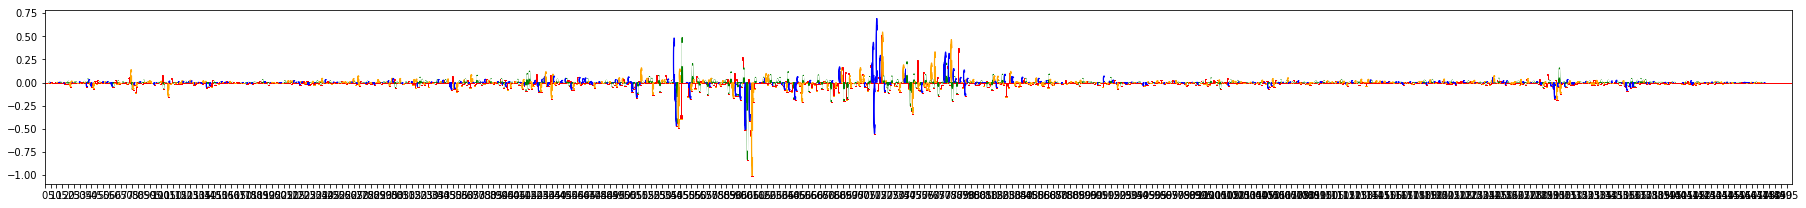

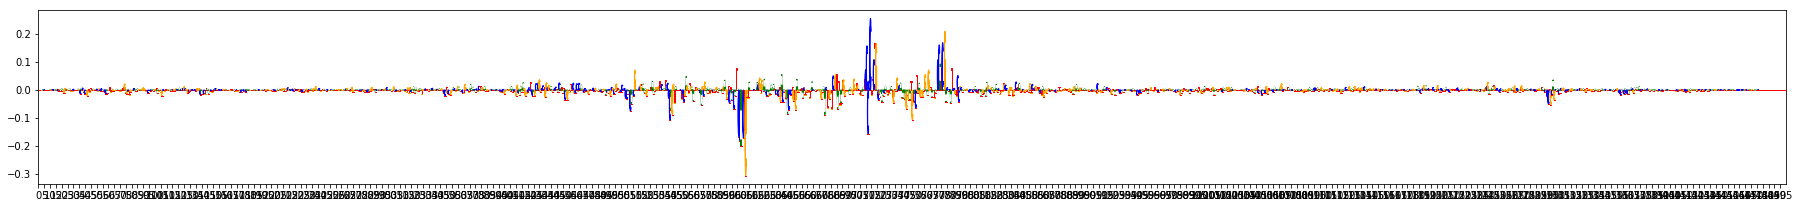

In [70]:
print("Negative:")
plot_seq_importance(gradinput_neg,neg_X)
plot_seq_importance(dl_neg,neg_X)

Positive:


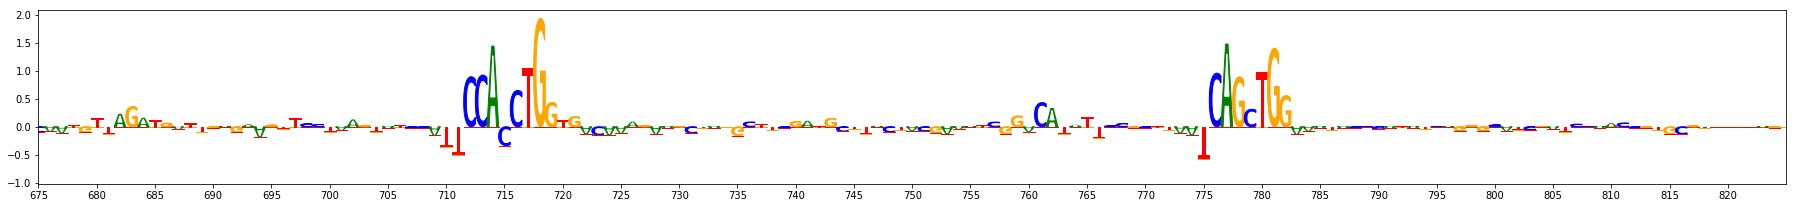

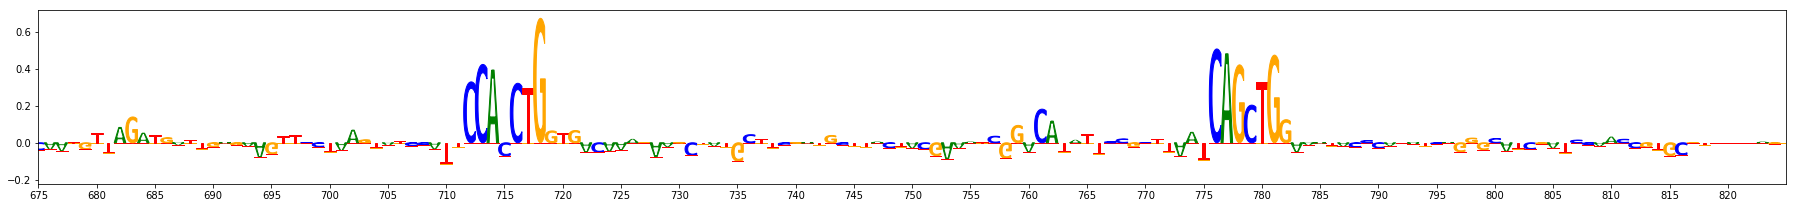

In [71]:
print("Positive:")
plot_seq_importance(gradinput_pos,pos_X,xlim=(675,825))
plot_seq_importance(dl_pos,pos_X,xlim=(675,825))

Negative:


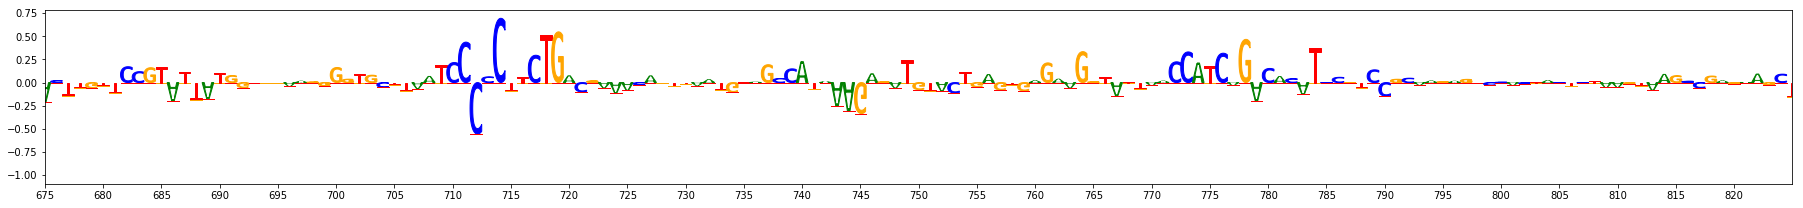

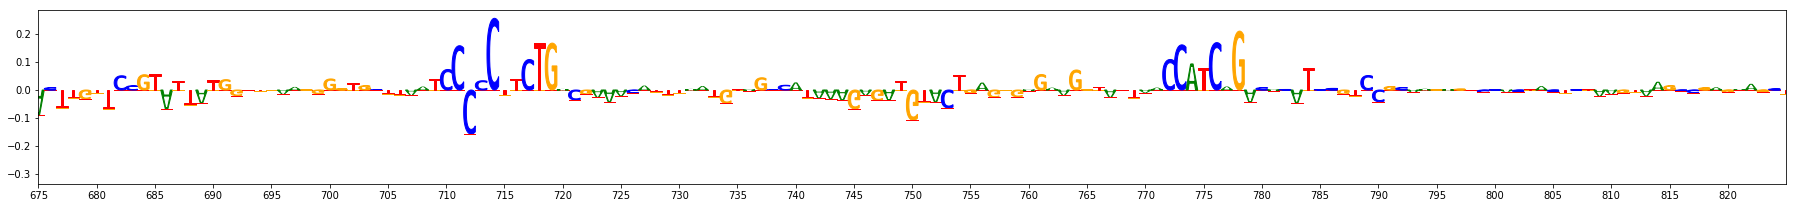

In [72]:
print("Negative:")
plot_seq_importance(gradinput_neg,neg_X,xlim=(675,825))
plot_seq_importance(dl_neg,neg_X,xlim=(675,825))

As expected, dropout decreased the overfitting this model displayed previously and increased test performance. Let's see the learned filters.

### Saving a keras model 


We save the optimal regularized multi-layer keras model to an hdf5 file that contains both the model weights and architecture.

In [ ]:
regularized_keras_model.save("TAL1.Simulation.Regularized.3ConvLayers.hdf5")

We can now load the saved model for use in other applications or for further fine-tuning:

In [ ]:
from keras.models import load_model
model=load_model("TAL1.Simulation.Regularized.3ConvLayers.hdf5")

## Comparison to LSGKM 

@Av 

## For further exploration<a name='11'>
<a href=#outline>Home</a>

In this tutorial we explored modeling of homotypic motif density. Other properties of regulatory DNA sequence include
![sequence properties 3](./tutorial_images/sequence_properties_3.jpg)
![sequence properties 4](./tutorial_images/sequence_properties_4.jpg)

DragoNN provides simulations that formulate learning these patterns into classification problems:
![sequence](./tutorial_images/sequence_simulations.png)

You can view the available simulation functions by running print_available_simulations:

In [72]:
print_available_simulations()

simulate_differential_accessibility
simulate_heterodimer_grammar
simulate_motif_counting
simulate_motif_density_localization
simulate_multi_motif_embedding
simulate_single_motif_detection


## Using DragoNN with your own non-simulated data<a name='12'>
<a href=#outline>Home</a>